In [1]:
print("strawberry")

import torch
import numpy as np
import torch.nn.functional as F
from torch.distributions import constraints
from torch.distributions.distribution import Distribution
from torch.distributions.multivariate_normal import _batch_mahalanobis, _batch_mv
from torch.distributions.utils import _standard_normal, lazy_property

# dataset
from torch.utils.data import Dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import argparse

import torch.nn as nn
import torch
from torchmetrics import Metric
import math

strawberry


In [2]:
def two_class_prob(p_hat):
    p_hat = torch.nn.functional.softmax(p_hat, dim=1)
    p_hat = p_hat[:,1,:] # select class 0
    return p_hat

def individual_dice(p_hat, y_true):
    p_hat = two_class_prob(p_hat)
    s0 = p_hat.shape[0]
    p_hat = p_hat.view(s0,-1)
    y_true = y_true.view(s0,-1)
    numerator = torch.sum(2. * p_hat * y_true, dim=1) + 1.
    denominator = torch.sum(y_true + p_hat, dim=1) + 1.
    combined = 1. - (numerator/denominator)
    return combined
    
def dice_loss(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    
    # is empties
    locs = torch.sum(y_true, dim=(-2, -1)) == 0
    wheres = torch.where(locs)[0]
    #print(wheres.shape)
    # print(wheres)
    #print(combined)
    r = 0.5
    combined[wheres] *= r
    #print(combined)
    
    return torch.sum(combined) / ((y_true.shape[0] - wheres.shape[0]) + (wheres.shape[0] * r))

def dice_loss_old(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    return torch.mean(combined)

def construct_parser():
    parser = argparse.ArgumentParser(description = "train models")
    
    parser.add_argument('--ckpt_dir', default=None, type=str)
    parser.add_argument('--kl_factor', default=0.1, type=float)
    return parser

def get_transforms():
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        RandomAffine(p=0.2, shear=(-18,18)),
        RandomAffine(p=0.2, degrees=15),
        RandomAffine(p=0.2, translate=(-0.1,0.1)),
        RandomAffine(p=0.2, scale=(0.9, 1.1)),
#         #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))

#         #RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
            
    ]
    transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
    return PairedCompose(transforms)

def none_transform():
    transforms = [
        LabelSelect(label_id=1),
        lambda x, y: (x, y.squeeze().type(torch.long))
    ]
    return PairedCompose(transforms)

def train_val_test_split(dataset, val_prop, test_prop, seed):
        # I think the sklearn version might be prefereable for determinism and things
        # but that involves fiddling with the dataset implementation I think....
        size = len(dataset)
        test_size = int(test_prop*size) 
        val_size = int(val_prop*size)
        train_size = size - val_size - test_size
        train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
        return train, val, test

In [3]:
    
import torch
import torch.nn as nn
from trustworthai.models.uq_models.drop_UNet import normalization_layer
import torch.nn.functional as F
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
import torch.distributions as td
from typing import Tuple

### 3d to 2d dataset
class MRISegDataset2DFrom3D(Dataset):
    def __init__(self, dataset3D, transforms=None):
        # calculate total number of slices (note need to iterate through every item
        # because each image may have a different number of slices
        size = 0
        for data in dataset3D:
            x = data[0]
            size += x.shape[1]
            
        self.size = size
        self.dataset3D = dataset3D
        self.transforms = transforms
        
        idx_to_scan_index = []
        scan_starting_index = []
        
        scan_count = 0
        starting_index = 0
        for (ind, _) in dataset3D:
            d_size = ind.shape[1] # slices are the second dim of 3D scan
            idx_to_scan_index.append(torch.ones(d_size) * scan_count)
            scan_starting_index.append(starting_index)
            
            scan_count += 1
            starting_index += d_size
            
        self.idx_to_scan = torch.cat(idx_to_scan_index, dim=0).type(torch.int32)
        # print(self.idx_to_scan.shape)
        self.scan_starting_index = scan_starting_index
        
    def __getitem__(self, idx):
        # find out which scan to use
        scan_idx = self.idx_to_scan[idx]
        # get that dataset
        scan_img, scan_label = self.dataset3D[scan_idx]
        # find out where the element is in that dataset
        item_idx = idx - self.scan_starting_index[scan_idx]
        
        #print(scan_img.shape, scan_label.shape)
        slice_x = scan_img[:, item_idx]
        slice_y = scan_label[:, item_idx] # slices are the second dim of a 3D scan (its channels, z, x, y for 3D scans)
        
        if self.transforms:
            slice_x, slice_y = self.transforms(slice_x, slice_y)
        
        return slice_x, slice_y
        
    def __len__(self):
        return self.size
    
### empty slice splitting
class FilteredEmptyElementsDataset(Dataset):
    def __init__(self, dataset, seed, transforms=None, empty_proportion_retained=0.1):
        # print(len(dataset))
        self.base_dataset = dataset
        self.transforms = transforms
        empty_indices = []
        self.non_empty_indices = []
        count = 0
        for i, (x, y) in enumerate(dataset):
            if y.sum() == 0:
                count += 1
                empty_indices.append(i)
            else:
                self.non_empty_indices.append(i)
           
        # print(count)
        # print(len(self.non_empty_indices))
        #print(count * empty_proportion_retained)
                
        # extract only a limited proportion of empty slices (take a random selection)
        shuffled_indices = torch.randperm(count, generator=torch.Generator().manual_seed(seed))
        emtpy_indices = torch.Tensor(empty_indices)
        self.retained_empty_indices = torch.Tensor(empty_indices)[shuffled_indices[0:int(count * empty_proportion_retained)]]
        self.size = len(self.non_empty_indices) + len(self.retained_empty_indices)
        self.non_empty_size = len(self.non_empty_indices)
        
            
    def __getitem__(self, idx):
        if idx >= self.non_empty_size:
            # select an empty slice
            new_idx = self.retained_empty_indices[idx - self.non_empty_size]
        else:
            # select a slice with label in it
            new_idx = self.non_empty_indices[idx]
        new_idx = int(new_idx)
        
        img, label = self.base_dataset[new_idx]
        
        if self.transforms:
            img, label = self.transforms(img, label)
            
        return img, label

    def __len__(self):
        return self.size

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as transforms

class HmResBlock(nn.Module):
    def __init__(self, channels, p):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=7, stride=1, dilation=2, padding='same')
        self.dropout1 = nn.Dropout2d(p)
        self.norm1 = nn.InstanceNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, dilation=2, padding='same')
        self.norm2 = nn.InstanceNorm2d(channels)
        self.activ = nn.ReLU()
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.activ(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.activ(out)
        
        out = out + identity
        
        return out
    
class DownBlock(nn.Module):
    def __init__(self, ins, outs):
        super().__init__()
        self.conv = nn.Conv2d(ins, outs, kernel_size=3, stride=2, dilation=1, padding=1)
        self.norm = nn.InstanceNorm2d(outs)
        self.activ = nn.ReLU()
        
    def forward(self, x):
        return self.activ(self.norm(self.conv(x)))

class HmUpsampBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels*2, channels, kernel_size=3, stride=1, dilation=1, padding='same')
        self.norm = nn.InstanceNorm2d(channels)
        self.activ = nn.ReLU()
        
    def forward(self, x):
        out = F.interpolate(x, scale_factor=2, mode='bilinear')
        return self.activ(self.norm(self.conv(out)))
        

class HmFeatureBlock(nn.Module):
    def __init__(self, ins):
        super().__init__()
        self.conv1 = nn.Conv2d(ins, ins//2, kernel_size=3, stride=1, dilation=2, padding='same')
        self.activ = nn.ReLU()
        self.norm1 = nn.InstanceNorm2d(ins)
        self.conv2 = nn.Conv2d(ins//2, ins//2, kernel_size=1, stride=1, dilation=1)
        self.norm2 = nn.InstanceNorm2d(ins)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.activ(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.activ(out)
        
        return out
    
class HyperMapREDO(nn.Module):
    def __init__(self,dropout_p = 0., encoder_sizes=[16,32,64,128,256], inchannels=3, outchannels=2):
        super().__init__()
        
        
        # input layer
        self.conv_first = nn.Conv2d(inchannels, encoder_sizes[0], kernel_size=5, stride=1, dilation=1, padding='same')
        self.activ = nn.ReLU()
        
        # encoder section
        l = len(encoder_sizes) - 1
        self.down_blocks = nn.ModuleList([
            DownBlock(encoder_sizes[i], encoder_sizes[i+1]) for i in range(0, l)
        ])
        
        self.res_blocks = nn.ModuleList([
            HmResBlock(c, dropout_p) for c in encoder_sizes
        ])
        
        # decoder section
        self.upsample_blocks = nn.ModuleList([
            HmUpsampBlock(c) for c in encoder_sizes[:-1][::-1]
        ])
        
        self.feature_blocks = nn.ModuleList([
            HmFeatureBlock(encoder_sizes[l - i]) for i in range(l-1)
        ])
        
        
        # multi-scale feature section
        self.ms_feature_layers = nn.ModuleList([
            nn.Conv2d(encoder_sizes[2], encoder_sizes[1], 3, padding='same'),
            nn.Conv2d(encoder_sizes[1], encoder_sizes[1], 3, padding='same'),
            nn.Conv2d(encoder_sizes[1], encoder_sizes[1], 3, padding='same')
        ])
        
        
        # output layer
        self.last_1 = nn.Conv2d(encoder_sizes[1], encoder_sizes[1], 3, padding='same')
        self.last_2 = nn.Conv2d(encoder_sizes[1]*3, encoder_sizes[1], 1)
        self.last_3 = nn.Conv2d(encoder_sizes[1], outchannels, 1)
        self.last_norm = nn.InstanceNorm2d(encoder_sizes[1])
        
    def forward(self, x):
        # input layer
        out = self.activ(self.conv_first(x))
        # print(out.shape)
        
        skips = []
        
        # encoder section
        out = self.res_blocks[0](out)
        # print(out.shape)
        skips.append(out)
        for i in range(len(self.res_blocks) - 1):
            out = self.down_blocks[i](out)
            out = self.res_blocks[i+1](out)
            # print("loop: ", out.shape)
            skips.append(out)
        
        # decoder section
        ml_features = []
        out = skips.pop()
        for i in range(len(self.upsample_blocks)):
            # print("dec")
            if i > 0:
                sk = skips.pop()
                sk = transforms.center_crop(sk, out.shape[-2:])
                out = torch.cat([out, sk], dim=1)
                out = self.feature_blocks[i-1](out)
            
            if i > 1:
                ml_features.append(self.ms_feature_layers[i-2](out))
                
            out = self.upsample_blocks[i](out)
        
        # final layers
        sk = skips.pop()
        sk = transforms.center_crop(sk, out.shape[-2:])
        out = torch.cat([out, sk], dim=1)
        out = self.last_norm(self.activ(self.last_1(out)))
        
        # multiscale feature section
        ml_features = [out] + ml_features
        ml_features = [F.interpolate(mf, size=x.shape[-2:], mode='bilinear') for mf in ml_features]
        combined_features = torch.cat(ml_features, dim=1)
        
        out = self.activ(self.last_2(combined_features))
        out = self.last_3(out)
        
        return out


def get_conv_func(dims, transpose=False):
    # determine convolution func
        if dims == 2:
            if transpose:
                return nn.ConvTranspose2d
            else:
                return nn.Conv2d
        elif dims == 3:
            if transpose:
                return nn.ConvTranspose3d
            else:
                return nn.Conv3d
        else:
            raise ValueError(f"values of dims of 2 or 3 (2D or 2D conv) are supported only, not {dims}")
            
def get_dropout_func(dims):
    if dims == 2:
        return nn.Dropout2d
    if dims == 3:
        return nn.Dropout3d
    else:
        return nn.Dropout

In [5]:
class StandardLitModelWrapper(pl.LightningModule):
        def __init__(self, model, loss=F.cross_entropy, logging_metric=None, optimizer_params={"lr":1e-3}, lr_scheduler_params={"step_size":30, "gamma":0.1}, is_uq_model=False,
                    optimizer_constructor=None, lr_scheduler_constructor=None):
            super().__init__()
            self.model = model
            self.loss = loss
            self.logging_metric_train = logging_metric()
            self.logging_metric_val = logging_metric()
            self.optim_params = optimizer_params
            self.lr_scheduler_params = lr_scheduler_params
            self.is_uq_model = False
            self.optimizer_constructor = optimizer_constructor
            self.lr_scheduler_constructor = lr_scheduler_constructor


        def forward(self, x, **kwargs):
            return self.model(x, **kwargs)

        def configure_optimizers(self):
            # optimizer and schedulers go in the configure optimizers hook
            if self.optimizer_constructor:
                optimizer = self.optimizer_constructor(self.parameters(), **self.optim_params)
            else:
                optimizer = torch.optim.Adam(self.parameters(), **self.optim_params)

            if self.lr_scheduler_constructor:
                lr_scheduler = self.lr_scheduler_constructor(optimizer, **self.lr_scheduler_params)
            else:
                lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **self.lr_scheduler_params)

            return [optimizer], [lr_scheduler]

        def training_step(self, batch, batch_idx):
            """
            lightning automates the training loop, 
            does epoch, back_tracking, optimizers and schedulers,
            and metric reduction.
            we just define how we want to process a single batch. 
            we can optionally pass optimizer_idx if we want to define multiple optimizers within the configure_optimizers
            hook, and I presume we can add our own parameters also to functions?
            """

            if self.is_uq_model:
                self.model.set_applyfunc(True)

            X, y = batch
            y_hat = self(X)
            loss = self.loss(y_hat, y)

            # metrics 
            if self.logging_metric_train:
                self.logging_metric_train(y_hat, y)
                self.log(f"train_metric", self.logging_metric_train, on_step=True, on_epoch=False, prog_bar=True)
            self.log("train_loss", loss)

            return loss

    #     def training_epoch_end(self, outs):
    #         self.log('train_metric_epoch', self.logging_metric_train.compute())

    #     def validation_epoch_end(self, outs):
    #         self.log('val_metric_epoch', self.logging_metric_val.compute())

        def validation_step(self, batch, batch_idx):
            """
            note: call trainer.validate() automatically loads the best checkpoint if checkpointing was enabled during fitting
            well yes I want to enable checkpointing but will deal with that later.
            also it does stuff like model.eval() and torch.no_grad() automatically which is nice.
            I will need a custom eval thing to do my dropout estimation but can solve that later too.
            """
            if self.is_uq_model:
                self.model.set_applyfunc(False)

            X, y = batch
            y_hat = self(X)
            val_loss = self.loss(y_hat, y)

            if self.logging_metric_val:
                self.logging_metric_val(y_hat, y)
                self.log(f"val_metric", self.logging_metric_val, on_step=True, on_epoch=True, prog_bar=True)
            self.log("val_loss", val_loss)

        def test_step(self, batch, batch_idx):
            """
            we would need to directly call this function using the trainer
            """

            if self.is_uq_model:
                self.model.set_applyfunc(False)

            X, y = batch
            y_hat = self(X)
            test_loss = self.loss(y_hat, y)
            self.log("test_loss", test_loss)

        def predict_step(self, batch, batch_idx):
            """
            just for making predictions as opposed to collecting metrics etc
            note to use this, we just call .predict(dataloader) and it then automates the look
            these functions are for a single batch. Nice.
            """
            X, y = batch
            pred = self(X)
            return pred

In [10]:
is3D = False
    

test_proportion = 0.15
validation_proportion = 0.15
seed = 3407

# load datasets
# this step is quite slow, all the data is being loaded into memory
try:
    scratch_dir = "/disk/scratch/"
    root_dir = scratch_dir + "s2208943/ipdis/preprep/out_data/collated/"
    #root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
    wmh_dir = root_dir + "WMH_challenge_dataset/"
    ed_dir = root_dir + "EdData/"

    domains = [
                ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
              ]
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=None) for domain in domains]
except:
    scratch_dir = "/disk/scratch_big/"
    root_dir = scratch_dir + "s2208943/ipdis/preprep/out_data/collated/"

    wmh_dir = root_dir + "WMH_challenge_dataset/"
    ed_dir = root_dir + "EdData/"

    domains = [
                ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
              ]
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=None) for domain in domains]


# split into train, val test datasets
datasets_3d = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset_3d = ConcatDataset([ds[0] for ds in datasets_3d])
val_dataset_3d = ConcatDataset([ds[1] for ds in datasets_3d])
test_dataset_3d = ConcatDataset([ds[2] for ds in datasets_3d])

datasets_2d = [MRISegDataset2DFrom3D(ds, transforms=None) for ds in [train_dataset_3d, val_dataset_3d, test_dataset_3d]]
train_dataset, val_dataset, test_dataset = [FilteredEmptyElementsDataset(ds, seed=seed, transforms=get_transforms()) for ds in datasets_2d]

# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

### Evidential Functions

In [171]:
### functions for getting code from the evidential distribution. Nice.

def relu_evidence(logits):
    return torch.nn.functional.relu(logits)

def exp_evidence(logits):
    return logits.clamp(-10, 10).exp()

def softplus_evidence(logits):
    return torch.nn.functional.softplus(logits)


def get_S(alpha):
    # evidence is shape [b, c, <dims>], we want an S per pixel, so reduce on dim 1
    S = alpha.sum(dim = 1).unsqueeze(1)
    return S

def get_bk(evidence, S):
    return evidence / S

def get_uncert(K, S):
    return K / S

def get_alpha(evidence):
    #return (evidence + 1.)**2
    return (evidence + 1.)**2

def get_one_hot_target(K, target):
    one_hot = torch.zeros((target.shape[0], K, *target.shape[1:])).to(target.device)
    one_hot[:,0] = 1 - target
    one_hot[:,1] = target
    
    return one_hot

def get_mean_p_hat(alpha, S):
    return alpha / S

######
def digamma(values):
    return torch.digamma(values).clamp(-100,100)

def get_alpha_modified(alpha, one_hot_target):
    return one_hot_target + ((1 - one_hot_target) * alpha)

def xent_bayes_risk(alpha, S, one_hot_target):
    digamma_S = torch.digamma(S).expand(alpha.shape)
    digamma_alpha = torch.digamma(alpha)
    
    p_ij = one_hot_target * (digamma_S - digamma_alpha)
    per_pixel_loss =  torch.sum(p_ij, dim=1)
    
    return torch.sum(per_pixel_loss, dim=(-2,-1)).mean() # reduction = mean


def mse_bayes_risk(mean_p_hat, S, one_hot_target):
    l_err = torch.nn.functional.mse_loss(mean_p_hat, one_hot_target, reduction='none')
    
    l_var = mean_p_hat * (1.- mean_p_hat) / (S + 1.)
    
    return (l_err + l_var).sum(dim=(-2,-1)).mean()

class KL_Loss():
    def __init__(self, anneal=True):
        self.counter = 0
        self.anneal = anneal
        
    def __call__(self,alpha_modified):
        self.counter += 1
        #print(self.counter)
        K = alpha_modified.shape[1]
        beta = torch.ones((1, *alpha_modified.shape[1:])).to(alpha_modified.device)
        sum_alpha = alpha_modified.sum(dim=1)
        sum_beta = beta.sum(dim=1)

        lnB = torch.lgamma(sum_alpha) - torch.lgamma(alpha_modified).sum(dim=1)
        lnB_uni = torch.lgamma(beta).sum(dim=1) - torch.lgamma(sum_beta)

        dg0 = torch.digamma(sum_alpha).unsqueeze(1)
        dg1 = torch.digamma(alpha_modified)

        diff = (alpha_modified - beta)
        v = (dg1 - dg0)

        # print(sum_alpha.shape)
        # print(sum_beta.shape)
        # print(diff.shape)
        # print(v.shape)

        rhs = torch.sum(diff * v, dim=1)

        kl = lnB + lnB_uni + rhs

        # the early stopping checks val loss every three epochs. There are about 150
        # batches per train iteration currently, so 150*4, anneal in 4 epochs.
        if self.anneal:
            return torch.mean(kl, dim=(-2,-1)).mean() * (min(1, self.counter/(150*4))**2)
            # return torch.sum(kl, dim=(-2,-1)).mean() * (min(1, self.counter/(150*4))**2)
        else:
            return torch.mean(kl, dim=(-2,-1)).mean()
            # return torch.sum(kl, dim=(-2,-1)).mean()
    
KL = KL_Loss()

def dice_bayes_risk(K, alpha, one_hot_target, S):
    bs = alpha.shape[0]
    alpha = alpha.view(bs, K, -1)
    one_hot_target = one_hot_target.view(bs, K, -1)
    S = S.view(bs, 1, -1)
    #print(one_hot_target.shape, alpha.shape, S.shape)
    numerator = torch.sum(one_hot_target * alpha / S, dim=2)
    denominator = torch.sum(one_hot_target ** 2 + (alpha/S)**2 + (alpha*(S-alpha)/((S**2)*(S+1))), dim=2)
    dice= 1 - (2/K) * ((numerator/denominator).sum(dim=1))
    #print(dice.shape)
    return dice.mean()

In [172]:
torch.digamma(torch.Tensor([1.5]))

tensor([0.0365])

In [202]:
kl_factor = 0.1
dice_factor = 5

def combined_loss(logits, target, kl_obj=KL):
    # get relevent terms required for loss func
    evidence = softplus_evidence(logits)
    alpha = get_alpha(evidence)
    S = get_S(alpha)
    K = alpha.shape[1]
    one_hot = get_one_hot_target(K, target)
    mean_p_hat = get_mean_p_hat(alpha, S)
    alpha_modified = get_alpha_modified(alpha, one_hot)


    #mse = mse_bayes_risk(mean_p_hat, S, one_hot)
    xent = xent_bayes_risk(alpha, S, one_hot)
    dice = dice_bayes_risk(K, alpha, one_hot, S)
    # dice = dice_loss(mean_p_hat, target)
    
    kl = kl_obj(alpha_modified)
    

    return dice + (kl_factor * kl)
    # print(xent*0.2, kl*0.2, dice * dice_factor)
    # return xent*0.2 + kl * 0.2 + dice * dice_factor
    # return xent + (kl_factor * kl)

In [203]:
from torchmetrics import Metric

class FullKLEvidMetric(Metric):
    is_differentiable = False
    higher_is_better = True
    full_state_update = False
    def __init__(self):
        super().__init__()
        self.add_state("value", default=torch.tensor(0, dtype=torch.float32), dist_reduce_fx=None)
        self.kl_obj = KL_Loss(anneal=False)

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        self.value =  combined_loss(preds, target, self.kl_obj)

    def compute(self):
        return self.value

In [204]:
ckpt_dir = "/home/s2208943/ipdis/tests_dump"

In [205]:
# define the model.
model_raw  = HyperMapREDO().cuda()

In [206]:
loss = combined_loss

optimizer_params={"lr":2e-4}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[1000], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

model = StandardLitModelWrapper(model_raw, loss, 
                                logging_metric=FullKLEvidMetric,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )

In [207]:
accelerator="gpu"
devices=1
max_epochs=100
precision = 32

# rootdir = scratch_dir + "s2208943/results/revamped_models/"
# final_dir = rootdir + ckpt_dir
final_dir = ckpt_dir
checkpoint_callback = ModelCheckpoint(final_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_metric", min_delta=0.01, patience=15, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    precision=precision,
    default_root_dir=final_dir
)

trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type             | Params
----------------------------------------------------------
0 | model                | HyperMapREDO     | 6.3 M 
1 | logging_metric_train | FullKLEvidMetric | 0     
2 | logging_metric_val   | FullKLEvidMetric | 0     
----------------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.231    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_metric improved. New best score: 0.501


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [208]:
trainer.validate(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.2313690036535263
    val_metric_epoch         0.500460147857666
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_metric_epoch': 0.500460147857666, 'val_loss': 0.2313690036535263}]

In [209]:
x, y = next(iter(val_dataloader))

In [210]:
with torch.no_grad():
    pred = model(x.to(model.device))

In [211]:
o = pred.argmax(dim=1).cpu()
p = pred[:,1].cpu()

In [212]:
burden = y.sum(dim=(1,2))

In [213]:
ids_by_burden = torch.sort(burden, descending=True)[1]

In [214]:
ids_by_burden

tensor([18, 19, 20, 17,  5,  4, 16, 13,  3,  2,  6,  7, 15,  9, 12, 14, 21, 11,
        10,  8, 22, 23, 27, 29, 30, 31, 28, 26, 25,  1, 24,  0])

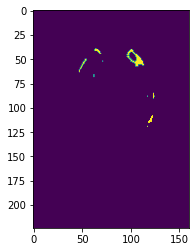

In [215]:
plt.imshow(y[5])

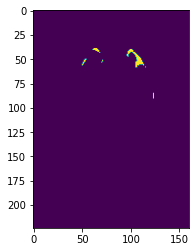

In [216]:
plt.imshow(o[5])

In [217]:
def batch_ent(batch):
    probs = torch.nn.functional.softmax(batch, dim=1)
    ent_map = torch.sum(-probs * torch.log(probs+1e-30), dim=1)
    return ent_map

def epistemic_uncert(K, S):
    return K / S

def aleotoric_uncert(alpha, S):
    lhs = torch.digamma(alpha + 1)
    rhs = torch.digamma(S + 1)
    
    frac = alpha / S
    
    return -torch.sum(frac * (lhs - rhs), dim=1)
    
    
def distributional_uncert(alpha, S):
    frac = alpha / S
    rhs = torch.log(frac) - torch.digamma(alpha + 1) + torch.digamma(S + 1)
    return -torch.sum(frac * rhs, dim=1)

def pred_entropy(alpha, S):
    mu = alpha / S
    return batch_ent(mu)

In [218]:
logits = pred.cpu()
target = y
evidence = softplus_evidence(logits)
alpha = get_alpha(evidence)
S = get_S(alpha)
K = alpha.shape[1]
one_hot = get_one_hot_target(K, target)
mean_p_hat = get_mean_p_hat(alpha, S)
alpha_modified = get_alpha_modified(alpha, one_hot)

In [219]:
e_uncert = epistemic_uncert(K, S)
a_uncert = aleotoric_uncert(alpha, S)
d_uncert = distributional_uncert(alpha, S)
p_uncert = pred_entropy(alpha, S)

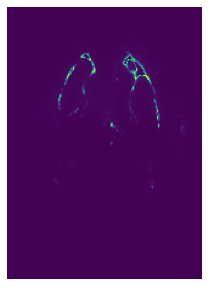

In [220]:
plt.figure(figsize=(7,5))
plt.imshow(p_uncert[5].squeeze());
plt.axis('off');

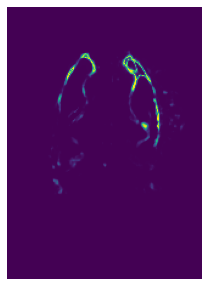

In [201]:
plt.figure(figsize=(7,5))
plt.imshow(p_uncert[5].squeeze());
plt.axis('off');

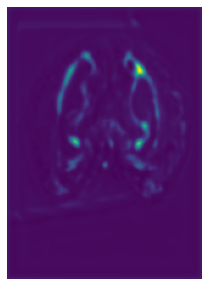

In [149]:
plt.figure(figsize=(7,5))
plt.imshow(p[5].squeeze());
plt.axis('off');